In [1]:
import os

# Data path
DATA_FOLDER = "../data"
TRAIN_FILE= os.path.join(DATA_FOLDER, "Shakespeare_clean_train.txt")
TEST_FILE= os.path.join(DATA_FOLDER, "Shakespeare_clean_test.txt")
VALIDATION_FILE= os.path.join(DATA_FOLDER, "Shakespeare_clean_valid.txt")

In [2]:
import re
import math
from collections import defaultdict

# Count frequency of pairs of adjacent tokens 
def get_stats(vocab):
    pairs = defaultdict(int)
    for w, freq in vocab.items():
        symbols= w.split()
        for i in range(len(symbols) - 1):
            pairs[(symbols[i], symbols[i+1])] += freq
    return pairs

# Merge the most frequent pairs in the vocab
def merge_vocab(pair, vocab):
    new_vocab = defaultdict(int) 
    bigram = pair
    replacement = ''.join(pair)
    for word, freq in vocab.items():
        symbols = word.split()
        new_symbols = []
        i = 0
        while i < len(symbols):
            if i < len(symbols) -1 and (symbols[i], symbols[i+1]) ==bigram:
                new_symbols.append(replacement)
                i += 2
            else:
                new_symbols.append(symbols[i])
                i += 1
                
        new_w = ' '.join(new_symbols)
        new_vocab[new_w] += freq
    return new_vocab

def bpe_tokenize_word(word, merges):
    word_tokens = list(word) + ['</w>']

    for pair in merges:
        replacement = ''.join(pair)
        i = 0
        new_tokens = []
        while i < len(word_tokens):
            if i < len(word_tokens) - 1 and (word_tokens[i], word_tokens[i+1]) == pair:
                new_tokens.append(replacement)
                i += 2
            else:
                new_tokens.append(word_tokens[i])
                i += 1
        word_tokens = new_tokens  # Update tokens after each merge

    return word_tokens 

# Get the subword token vocabulary from the encoded vocabulary
def get_subword_token_vocab(encoded_vocab):
    tokens = set()
    for word in encoded_vocab:
        tokens.update(word.split())
    return tokens

# Apply Byte Pair Encoder on the input text
def byte_pair_encoding(text, num_merges):
    # initialize vocab
    vocab = defaultdict(int)
    words = text.split()
    
    for w in words:
        # Example: "hello" becomes "h e l l o </w>"
        vocab[' '.join(list(w)) +'</w>'] += 1
        
    merges = [] # To store the learned merges for later tokenization 
    
    for merge_num in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            # print(f'No more pairs to merge after {merge_num} merges. Breaking.') # Optional debug
            break
        best_pair = max(pairs, key=pairs.get)
        print(f"Merge {merge_num + 1}: {best_pair}")
        vocab = merge_vocab(best_pair, vocab)
        merges.append(best_pair) # Store the merge rule
    
    return vocab, merges

#Calculate the preplexity of the encoded vocab on the validation text 
def calculate_perplexity(encoded_vocab, merges, valid_text):
    words = valid_text.split()
    num_validation_words = len(words)
    total_merged_word_forms_count = sum(encoded_vocab.values())
    
    log_prob_sum = 0.0
    

    if total_merged_word_forms_count == 0:
        return float('inf') # Cannot calculate perplexity if no training data or vocab is empty
    
    for w in words:
        # Tokenize each validation word using the learned BPE merges
        bpe_tokenized_word_form = ''.join(bpe_tokenize_word(w, merges))
        #if bpe_tokenized_word_form not in encoded_vocab:
            #print(f'Unknown tokenized form: {bpe_tokenized_word_form}')  # Debug
        if bpe_tokenized_word_form in encoded_vocab:
            prob = encoded_vocab[bpe_tokenized_word_form] / total_merged_word_forms_count
            log_prob_sum += math.log(prob)
        else:
            # Smoothing for unknown word forms in validation set
            # This is applied when a full BPE-tokenized word form (e.g., "un k n o w n </w>")
            # is not found in the training vocabulary.
            log_prob_sum += math.log(1e-10) # smoothing for unknown word forms
        #print(f"BPE for '{w}': {bpe_tokenized_word_form}")
        
    if num_validation_words == 0: # Avoid division by zero for perplexity calculation
        return float('inf')

    perplexity = math.exp(-log_prob_sum / num_validation_words)
    return perplexity

def load_text(file_path):
    """Load text from a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()



In [3]:
# Load and preprocess training and validation texts
train_text = load_text(TRAIN_FILE).lower()
valid_text = load_text(VALIDATION_FILE).lower()

# Apply Byte Pair Encoding 
# List of different numbers of merges
num_merges_list = [1200, 2000, 2800, 3600, 4400, 5200, 6000] # Using original numbers

perplexities = {}
subword_vocab_sizes = {}

# Apply BPE and calculate perplexity for each number of merges
perplexities = {}
for num_merges in num_merges_list:
    # FIX: Capture both encoded_vocab and the learned merges
    encoded_vocab, merges = byte_pair_encoding(train_text, num_merges)
    print(f"After {num_merges} merges, sample vocab: {list(encoded_vocab.keys())[:10]}")  # Print a few vocab keys
    # Get subword vocabulary and print its size
    subword_vocab = get_subword_token_vocab(encoded_vocab)
    vocab_size = len(subword_vocab)
    subword_vocab_sizes[num_merges] = vocab_size  # Store for plotting
    print(f'Subword token vocabulary size for {num_merges} merges: {len(subword_vocab)}')
    # FIX: Pass the merges to the perplexity calculation
    perplexity = calculate_perplexity(encoded_vocab, merges, valid_text) 
    perplexities[num_merges] = perplexity
    print(f'Perplexity for {num_merges} merges: {perplexity}')

Merge 1: ('t', 'h')
Merge 2: ('a', 'n')
Merge 3: ('e', 'r')
Merge 4: ('o', 'u')
Merge 5: ('i', 'n')
Merge 6: ('e', 'n')
Merge 7: ('th', 'e</w>')
Merge 8: ('a', 'r')
Merge 9: ('h', 'a')
Merge 10: ('an', 'd</w>')
Merge 11: ('o', 'r')
Merge 12: ('o', 'n')
Merge 13: ('e', 's')
Merge 14: ('i', 's</w>')
Merge 15: ('e', 'a')
Merge 16: ('n', 'o')
Merge 17: ('t', 'o</w>')
Merge 18: ('l', 'l</w>')
Merge 19: ('e', 'r</w>')
Merge 20: ('i', 't')
Merge 21: ('o', 'f</w>')
Merge 22: ('o', 'u</w>')
Merge 23: ('e', ',</w>')
Merge 24: ('e', 'l')
Merge 25: ('s', 't')
Merge 26: ('l', 'e')
Merge 27: ('o', 'm')
Merge 28: ('th', 'a')
Merge 29: ('i', 'n</w>')
Merge 30: ('m', 'a')
Merge 31: ('h', 'i')
Merge 32: ('v', 'e</w>')
Merge 33: ('m', 'y</w>')
Merge 34: ('l', 'o')
Merge 35: ('c', 'a')
Merge 36: ('r', 'o')
Merge 37: ('th', 'e')
Merge 38: ('y', 'ou')
Merge 39: ('l', 'a')
Merge 40: ('t', 'i')
Merge 41: ('y', 'ou</w>')
Merge 42: ('o', 'r</w>')
Merge 43: ('tha', 't</w>')
Merge 44: ('l', 'i')
Merge 45: ('in', 

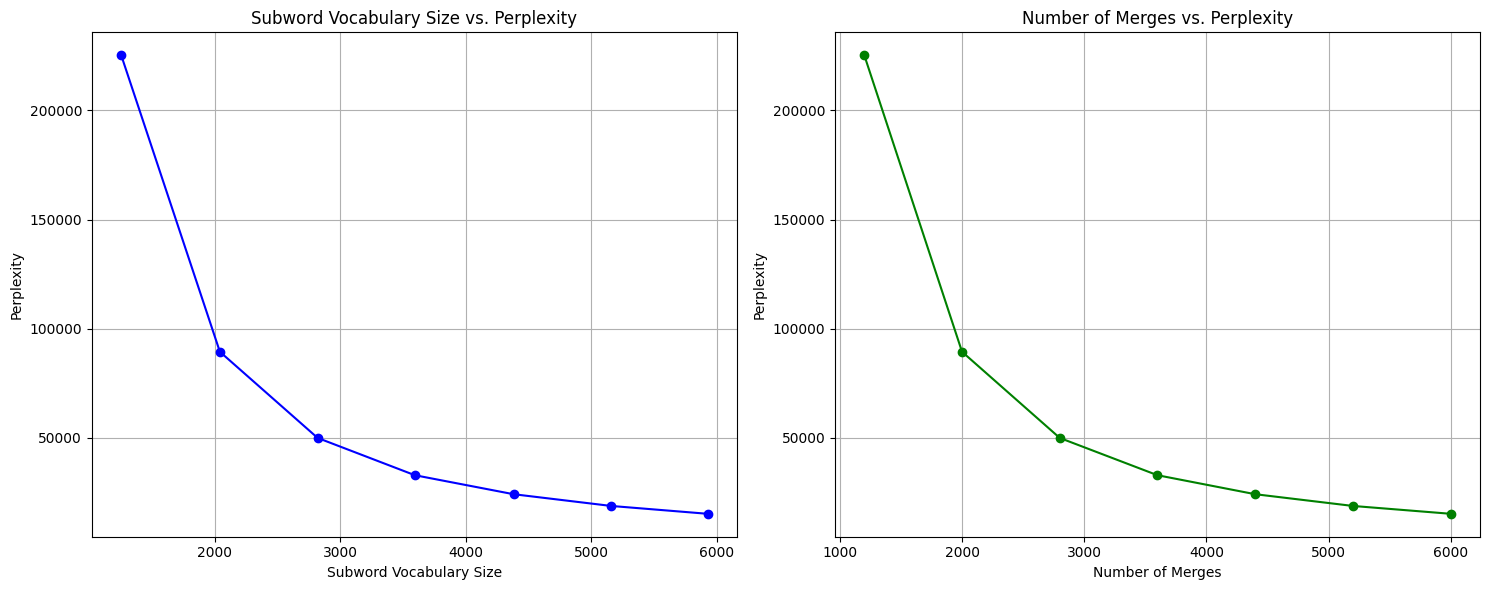

In [6]:
import matplotlib.pyplot as plt

# Plotting vocab size vs perplexity and number of merges vs perplexity
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Subword vocab size vs perplexity
ax[0].plot([subword_vocab_sizes[m] for m in num_merges_list], 
           [perplexities[m] for m in num_merges_list], 
           marker='o', linestyle='-', color='blue')
ax[0].set_xlabel('Subword Vocabulary Size')
ax[0].set_ylabel('Perplexity')
ax[0].set_title('Subword Vocabulary Size vs. Perplexity')
ax[0].grid(True)

# Subplot 2: Number of merges vs perplexity
ax[1].plot(num_merges_list, 
           [perplexities[m] for m in num_merges_list], 
           marker='o', linestyle='-', color='green')
ax[1].set_xlabel('Number of Merges')
ax[1].set_ylabel('Perplexity')
ax[1].set_title('Number of Merges vs. Perplexity')
ax[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Calculate tokenization efficiency
def calculate_tokenization_effeciency(encoded_vocab, origianl_text):
    original_tokens = len(original_text.split())
    encoded_tokens = len(encoded_vocab)

    effieciency = encoded_tokens / original_tokens
    return effieciency

# Calculate tokenization efficiency
tokenization_efficiency = calculate_tokenization_efficiency(encoded_vocab, training_text)
print(f'Tokenization Efficiency: {tokenization_efficiency}')

In [5]:
import math
import random
from collections import defaultdict, Counter

# Helper function to get subword token vocabulary
def get_subword_token_vocab(encoded_vocab):
    subword_vocab = set()
    for word in encoded_vocab:
        subword_vocab.update(word.split())
    return subword_vocab

# Count frequency of pairs of adjacent tokens 
def get_stats(vocab):
    pairs = defaultdict(int)
    for w, freq in vocab.items():
        symbols = w.split()
        for i in range(len(symbols) - 1):
            pairs[(symbols[i], symbols[i+1])] += freq
    return pairs

# Merge the most frequent pairs in the vocab
def merge_vocab(pair, vocab):
    new_vocab = defaultdict(int) 
    bigram = pair
    replacement = ''.join(pair)
    for word, freq in vocab.items():
        symbols = word.split()
        new_symbols = []
        i = 0
        while i < len(symbols):
            if i < len(symbols) - 1 and (symbols[i], symbols[i+1]) == bigram:
                new_symbols.append(replacement)
                i += 2
            else:
                new_symbols.append(symbols[i])
                i += 1
        new_w = ' '.join(new_symbols)
        new_vocab[new_w] += freq
    return new_vocab

# BPE tokenization for a word
def bpe_tokenize_word(word, merges):
    word_tokens = list(word) + ['</w>']

    for pair in merges:
        replacement = ''.join(pair)
        i = 0
        new_tokens = []
        while i < len(word_tokens):
            if i < len(word_tokens) - 1 and (word_tokens[i], word_tokens[i+1]) == pair:
                new_tokens.append(replacement)
                i += 2
            else:
                new_tokens.append(word_tokens[i])
                i += 1
        word_tokens = new_tokens  # Update tokens after each merge

    return word_tokens  

# Apply Byte Pair Encoding (BPE) on the input text
def byte_pair_encoding(text, num_merges):
    vocab = defaultdict(int)
    words = text.split()
    
    for w in words:
        vocab[' '.join(list(w)) +'</w>'] += 1
        
    merges = [] 
    
    for merge_num in range(num_merges):
        pairs = get_stats(vocab)
        if not pairs:
            break
        best_pair = max(pairs, key=pairs.get)
        vocab = merge_vocab(best_pair, vocab)
        merges.append(best_pair) 
    
    return vocab, merges

# Generate n-grams
def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append(tuple(tokens[i:i+n]))
    return ngrams

# Count the frequency of n-grams in the tokenized text
def count_ngrams(text, n, merges):
    tokens = []
    for word in text.split():
        tokens.extend(bpe_tokenize_word(word, merges))
    
    ngrams = generate_ngrams(tokens, n)
    ngram_counts = Counter(ngrams)
    return ngram_counts

# Calculate the probability for each n-gram
def calculate_ngram_probabilities(ngram_counts, n):
    ngram_probs = {}
    for ngram, count in ngram_counts.items():
        prefix = ngram[:-1]
        prefix_count = ngram_counts.get(prefix, 0)
        if prefix_count > 0:
            prob = count / prefix_count
        else:
            prob = 0
        ngram_probs[ngram] = prob
    return ngram_probs

# Laplace smoothing for unseen n-grams
def laplace_smoothing(ngram_counts, ngram_probs, vocab_size, alpha=1):
    smoothed_probs = {}
    for ngram, count in ngram_counts.items():
        prefix = ngram[:-1]
        prefix_count = ngram_counts.get(prefix, 0)
        smoothed_probs[ngram] = (count + alpha) / (prefix_count + alpha * vocab_size)
    return smoothed_probs

# Generate text using the n-gram model
def generate_text(ngram_probs, n, start_token, length=50):
    current_token = start_token
    result = [current_token]

    for _ in range(length):
        next_tokens = [(ngram[-1], prob) for ngram, prob in ngram_probs.items() if ngram[:-1] == (current_token,)]
        
        if next_tokens:
            next_token = random.choices([token for token, _ in next_tokens], [prob for _, prob in next_tokens])[0]
            result.append(next_token)
            current_token = next_token
        else:
            break  # Stop if no valid next token is found
    
    return result

# Load the text from file
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Main driver to train BPE and N-gram model
def main():
    # Load the training data (ensure you set the file path)
    train_text = load_text(TRAIN_FILE).lower()
    
    # Apply BPE
    num_merges = 5200  # Adjust the number of merges as required
    encoded_vocab, merges = byte_pair_encoding(train_text, num_merges)
    
    # Generate n-grams and calculate probabilities for n = 2, 3, 4, 5
    ngram_models = {}
    for n in range(2, 6):
        print(f"Training {n}-gram model...")
        ngram_counts = count_ngrams(train_text, n, merges)
        ngram_probs = calculate_ngram_probabilities(ngram_counts, n)
        
        # Apply smoothing (Laplace smoothing)
        vocab_size = len(get_subword_token_vocab(encoded_vocab))
        smoothed_probs = laplace_smoothing(ngram_counts, ngram_probs, vocab_size)
        
        ngram_models[n] = smoothed_probs
        print(f"{n}-gram model trained successfully.")
    
    # Test text generation with a starting token (use any token that exists in the vocabulary)
    start_token = 'h'  # You can pick any token from your vocabulary
    n = 2  # Example: Bigram model
    generated_text = generate_text(ngram_models[n], n, start_token, length=50)
    print("Generated Text:")
    print(' '.join(generated_text))

if __name__ == "__main__":
    main()


Training 2-gram model...
2-gram model trained successfully.
Training 3-gram model...
3-gram model trained successfully.
Training 4-gram model...
4-gram model trained successfully.
Training 5-gram model...
5-gram model trained successfully.
Generated Text:
h : </w> her ! </w> be </w> is </w> to </w> b y </w> him </w> piti ful nes s </w> i' ll </w> me thought s </w> so : </w> awa ke </w> the </w> bernar do </w> her </w> gross nes s , </w> ma de d ,
